In [12]:
import h5py
import os
from collections import namedtuple
from functools import cache

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from genomic_utils.variant import Variant

In [13]:
VCFS_DIR = "/global/scratch/users/poojakathail/enformer/gtex_fine/vcf"
SAD_SCORES_DIR = "/global/scratch/users/poojakathail/enformer/gtex_fine/preds/"
SUSIE_DIR = "/global/scratch/users/poojakathail/enformer/gtex_fine/susie"
GTEX_GENES_PATH = "/clusterfs/nilah/pooja/genomes/gtex_genes.bed"

In [14]:
DNASE_TRACK_IDXS = {
    "Pancreas": 257,
    "Ovary": 439,
    "Liver": 452,
    "Uterus": 283,
    "Testis": 665,
    "Spleen": 594,
    "Lung": 245,
    "Thyroid": 241,
    "Prostate": 653,
    "Vagina": 382,
    "Stomach": 204,
    "Adrenal_Gland": 265,
    "Cells_EBV-transformed_lymphocytes": 69
}

CAGE_TRACK_IDXS = {
    "Pancreas": 4946,
    "Ovary": 4688,
    "Liver": 4686,
    "Uterus": 4910,
    "Testis": 4694,
    "Spleen": 4693,
    "Lung": 4687,
    "Thyroid": 4696,
    "Prostate": 4690,
    "Vagina": 5175,
    "Stomach": 4959,
    "Adrenal_Gland": 4977,
    "Cells_EBV-transformed_lymphocytes": 5110
}

In [15]:
Locus = namedtuple("Locus", ["chrom", "pos"])

@cache
def load_transcription_start_sites() -> dict[str, Locus]:
    gtex_genes = pd.read_csv(GTEX_GENES_PATH, sep="\t", header=0, usecols=["name", "chrom", "txStart"])
    gene_id_to_tss = {}
    for _, row in gtex_genes.iterrows():
        tss = Locus(row["chrom"], row["txStart"])
        gene_id_to_tss[row["name"]] = tss
    return gene_id_to_tss

In [16]:
def get_variants_in_vcf(vcf_path) -> set[str]:
    variant_ids = set()
    for line in open(vcf_path, "r"):
        if line.startswith("#"):
            continue
        row = line.strip().split("\t")
        variant_ids.add(row[2])
    return variant_ids


def load_susie_df(tissue: str, pos_variants: set[str], neg_variants: set[str]) -> pd.DataFrame:
    susie_path = os.path.join(SUSIE_DIR, f"{tissue}.tsv")
    susie_df = pd.read_csv(susie_path, sep="\t", header=0, index_col=0)
    
    # Subset to variants in the VCF 
    variants = pos_variants | neg_variants
    susie_df = susie_df[susie_df["variant"].isin(variants)].copy()
    assert len(variants) == len(set(susie_df["variant"]))
    
    susie_df["finemapped"] = susie_df["variant"].isin(pos_variants)
    return susie_df


def filter_susie_df(susie_df: pd.DataFrame) -> pd.DataFrame:    
    ### 1. FILTER PUTATIVELY CAUSAL VARIANTS
    causal_df = susie_df[susie_df["finemapped"]].copy()
    
    # Retain variants where the eQTL direction is the same in all genes.
    consistent_sign_variants = set()
    for variant, variant_df in causal_df.groupby("variant"):
        betas = variant_df["beta_marginal"].to_numpy()
        if np.all(betas >= 0) or np.all(betas <= 0):
            consistent_sign_variants.add(variant)
    causal_df = causal_df[causal_df["variant"].isin(consistent_sign_variants)].copy()
    
    # Remove (variant, gene) pairs with PIP <= 0.9
    causal_df = causal_df[causal_df["pip"] > 0.9].copy()
    
    ### 2. FILTER PUTATIVELY NONCAUSAL VARAINTS
    noncausal_df = susie_df[
        (~susie_df["finemapped"])
        & (susie_df["pip"] < 0.01)
        & (susie_df["z"].abs() > 4)
    ].copy()
    
    ### 3. COMBINE AND FILTER TO CLOSEST GENE
    susie_df = pd.concat((causal_df, noncausal_df))
    
    gene_id_to_tss = load_transcription_start_sites()
    assert (susie_df["chromosome"] == susie_df["gene"].apply(lambda g: gene_id_to_tss[g].chrom)).all()
    susie_df["TSS_dist"] = [
        abs(v_pos - gene_id_to_tss[gene].pos)
        for v_pos, gene in zip(susie_df["end"], susie_df["gene"])
    ]
    
    # Retain closest gene per variant
    closest_gene_idxs = susie_df.groupby("variant")["TSS_dist"].idxmin()
    susie_df = susie_df.loc[closest_gene_idxs].copy()
    
    # Keep eQTLs within Basenji2 receptive_field
    max_dist_away = (896 // 2 - 1) * 128
    susie_df = susie_df[susie_df["TSS_dist"] < max_dist_away].copy()
    
    return susie_df
    
    
def load_tissue_variants(tissue):
    pos_vcf_path = os.path.join(VCFS_DIR, f"{tissue}_pos.vcf")
    neg_vcf_path = os.path.join(VCFS_DIR, f"{tissue}_neg.vcf")
    
    pos_variants = get_variants_in_vcf(pos_vcf_path)
    neg_variants = get_variants_in_vcf(neg_vcf_path)
    assert len(pos_variants & neg_variants) == 0 # mutally exclusive
    
    # Load variants that are in VCF file
    susie_df = load_susie_df(tissue, pos_variants, neg_variants)
    
    # Filter variants
    susie_df = filter_susie_df(susie_df)
                    
    return susie_df

In [17]:
def get_sad_scores(
    h5_path: str, cage_idx: int, dnase_idx: int, verbose: bool = False
) -> tuple[dict[str, float], dict[str, float]]:
    with h5py.File(h5_path) as f:
        snps = f["snp"][:].astype(str)
        basenji2_refs = f["ref_allele"][:].astype(str)
        basenji2_alts = f["alt_allele"][:].astype(str)
        
        cage_sads = f["ALT_sum"][:, cage_idx] - f["REF_sum"][:, cage_idx]
        dnase_sads = f["ALT_sum"][:, dnase_idx] - f["REF_sum"][:, dnase_idx]
        
        # Check if any SAD scores need to be flipped because the REF,ALT in VCF referred to 
        # major allele,minor allele as opposed to hg38_ref,hg38_alt.
        # GTEx betas are all in terms of hg38_ref,hg38_alt.
        multiplier = np.ones_like(snps, dtype=np.float32)
        for i, (snp, basenji2_ref, basenji2_alt) in enumerate(zip(snps, basenji2_refs, basenji2_alts)):
            snp = snp.split("_")
            gtex_ref, gtex_alt = snp[2], snp[3]
            if (basenji2_ref == gtex_alt) and (basenji2_alt == gtex_ref):
                multiplier[i] = -1.0
        
        if verbose:
            print(f"Need to flip SAD score for {(multiplier < 0).sum()}/{multiplier.size} variants")
                
        cage_sads *= multiplier
        dnase_sads *= multiplier
        
        assert cage_sads.shape == dnase_sads.shape == snps.shape
        snp_to_cage_sad = {snp: sad for snp, sad in zip(snps, cage_sads)}
        snp_to_dnase_sad = {snp: sad for snp, sad in zip(snps, dnase_sads)}
    
    return (snp_to_cage_sad, snp_to_dnase_sad)
    

def add_replicate_sad_scores(eqtl_df: pd.DataFrame, tissue: str):
    cage_idx = CAGE_TRACK_IDXS[tissue]
    dnase_idx = DNASE_TRACK_IDXS[tissue]
    
    # Get scores per replicate
    for replicate in range(1, 6):
        pos_h5_path = os.path.join(SAD_SCORES_DIR, f"basenji2_{replicate}_{tissue}_pos_REF_ALT", "sad.h5")
        neg_h5_path = os.path.join(SAD_SCORES_DIR, f"basenji2_{replicate}_{tissue}_neg_REF_ALT", "sad.h5")
        
        pos_cage_sad_scores, pos_dnase_sad_scores = get_sad_scores(pos_h5_path, cage_idx, dnase_idx)
        neg_cage_sad_scores, neg_dnase_sad_scores = get_sad_scores(neg_h5_path, cage_idx, dnase_idx)
        
        cage_sad_scores = {**pos_cage_sad_scores, **neg_cage_sad_scores}
        dnase_sad_scores = {**pos_dnase_sad_scores, **neg_dnase_sad_scores}
        
        eqtl_df[f"CAGE_SAD_{replicate}"] = eqtl_df["variant"].map(cage_sad_scores)
        eqtl_df[f"DNase_SAD_{replicate}"] = eqtl_df["variant"].map(dnase_sad_scores)
        
        assert not eqtl_df[f"CAGE_SAD_{replicate}"].isnull().any()
        assert not eqtl_df[f"DNase_SAD_{replicate}"].isnull().any()
    
    # Add replicate consistency metrics
    cage_columns = [f"CAGE_SAD_{replicate}" for replicate in range(1, 6)]
    dnase_columns = [f"DNase_SAD_{replicate}" for replicate in range(1, 6)]

    eqtl_df["n_pos_CAGE_SAD"] = (eqtl_df[cage_columns] >= 0).sum(axis=1)
    eqtl_df["n_neg_CAGE_SAD"] = (eqtl_df[cage_columns] < 0).sum(axis=1)
    eqtl_df["n_agree_CAGE_SAD"] = eqtl_df[["n_pos_CAGE_SAD", "n_neg_CAGE_SAD"]].max(axis=1)

    eqtl_df["n_pos_DNase_SAD"] = (eqtl_df[dnase_columns] >= 0).sum(axis=1)
    eqtl_df["n_neg_DNase_SAD"] = (eqtl_df[dnase_columns] < 0).sum(axis=1)
    eqtl_df["n_agree_DNase_SAD"] = eqtl_df[["n_pos_DNase_SAD", "n_neg_DNase_SAD"]].max(axis=1)

In [18]:
eqtl_dfs = []
for tissue in tqdm(DNASE_TRACK_IDXS, desc="Tissues"):
    eqtl_df = load_tissue_variants(tissue)
    add_replicate_sad_scores(eqtl_df, tissue)
    eqtl_dfs.append(eqtl_df)
    
merged_eqtl_df = pd.concat(eqtl_dfs, axis=0)
merged_eqtl_df.to_csv("merged_eqtl_results.tsv", sep="\t")

Tissues: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]


In [19]:
merged_eqtl_df = pd.read_csv("merged_eqtl_results.tsv", sep="\t", index_col=0)

In [20]:
def rename_tissue(tissue: str) -> str:
    if tissue == "Adrenal_Gland":
        return "Adrenal Gland"
    elif tissue == "Cells_EBV-transformed_lymphocytes":
        return "EBV-transformed\nlymphocytes"
    return tissue

def plot_sign_consistency_results(eqtl_df: pd.DataFrame, assay: str = "CAGE"):
    assert assay in ["CAGE", "DNase"]
    
    # Subset to finemapped variants
    eqtl_df = eqtl_df[eqtl_df["finemapped"]].copy()
    
    # Get list of tissues, sorted by number of variants
    tissues = eqtl_df["tissue"].value_counts().index.tolist()    
    n_tissues = len(tissues)
    
    # Count the number of consistently correct, consistently incorrect, and inconsistent predictions
    n_consistent_correct = np.zeros((n_tissues), dtype=int)
    n_consistent_incorrect = np.zeros((n_tissues), dtype=int)
    n_inconsistent = np.zeros((n_tissues, 4), dtype=int)
    
    for tissue_idx, tissue in enumerate(tissues):
        tissue_df = eqtl_df[eqtl_df["tissue"] == tissue].copy()
        for beta, n_pos, n_neg in zip(
            tissue_df["beta_marginal"], tissue_df[f"n_pos_{assay}_SAD"], tissue_df[f"n_neg_{assay}_SAD"]
        ):
            n_correct_sad = n_pos if beta >= 0 else n_neg
            n_incorrect_sad = n_neg if beta >= 0 else n_neg
            if n_correct_sad == 5:
                n_consistent_correct[tissue_idx] += 1
            elif n_correct_sad == 0:
                n_consistent_incorrect[tissue_idx] += 1
            else:
                n_inconsistent[tissue_idx, n_correct_sad - 1] += 1
                
    n_total = n_consistent_correct + n_consistent_incorrect + n_inconsistent.sum(axis=1)
    frac_consistent_correct = n_consistent_correct / n_total
    frac_consistent_incorrect = n_consistent_incorrect / n_total
    frac_inconsistent = n_inconsistent / n_total[:, np.newaxis]
                
    # Plot
    bar_width = 0.2
    x = np.arange(n_tissues)
    
    fig, ax = plt.subplots(figsize=(13, 8))
    ax.bar(x, frac_consistent_correct, bar_width, label="consistently correct")
    
    frac_inconsistent_bottom = np.zeros((n_tissues))
    for i in range(n_inconsistent.shape[1] - 1, -1, -1):
        ax.bar(
            x + bar_width, 
            frac_inconsistent[:, i], 
            bar_width, 
            bottom=frac_inconsistent_bottom,
            label=f"inconsistent ({i + 1} correct)"
        )
        frac_inconsistent_bottom += frac_inconsistent[:, i]
        
    ax.bar(x + 2 * bar_width, frac_consistent_incorrect, bar_width, label="consistently incorrect")
    
    ax.set_xlabel("Tissues", fontsize=12)
    ax.set_ylabel("Proportion of eQTLs", fontsize=12)
    ax.set_title(f"Finemapped eQTL sign prediction (using {assay} tracks)", fontsize=14)
    
    tissue_counts = eqtl_df["tissue"].value_counts().to_dict()
    tissue_names = [f"{rename_tissue(t)}\n(N={tissue_counts[t]})" for t in tissues]
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(tissue_names, rotation=45, ha="center", fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1))
    
    plt.tight_layout()
    plt.show()

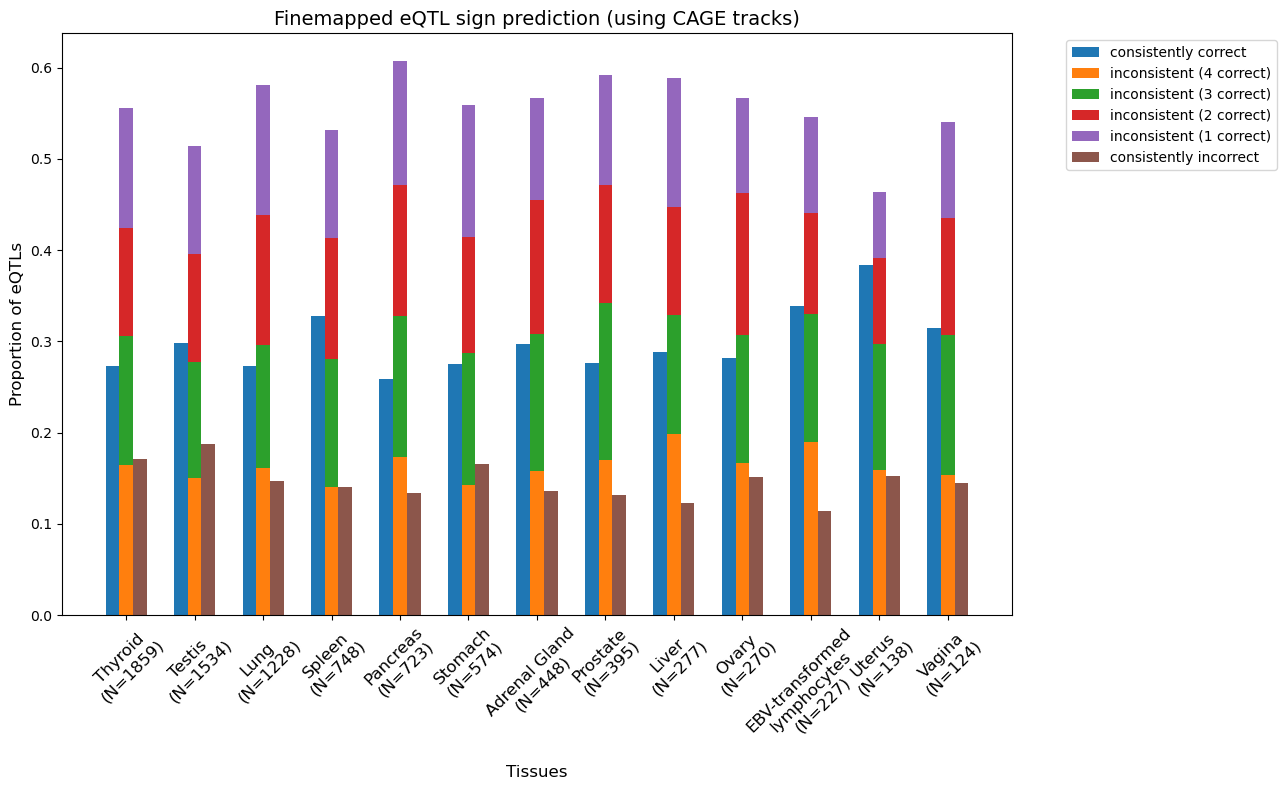

In [21]:
plot_sign_consistency_results(merged_eqtl_df, assay="CAGE")

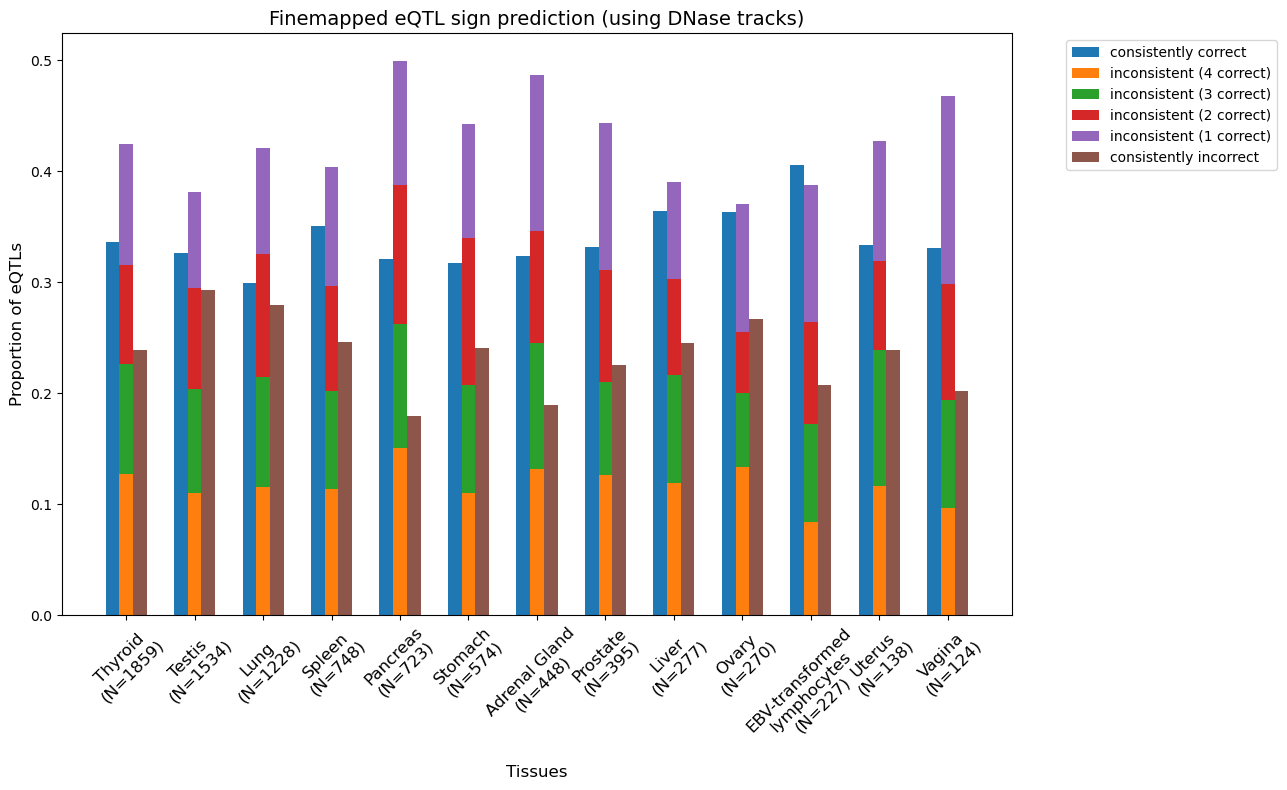

In [22]:
plot_sign_consistency_results(merged_eqtl_df, assay="DNase")